# LBM Step 1: Pre-Processing

Raw ScanImage .tiff files are saved to disk in an interleaved manner.

## Steps:

**1a.** Set up filepaths.

**1b.** Extract ScanImage metadata.

**1c.** Use metadata to de-interleave frames into planar timeseries.

**1d.** Correct Bi-Directional Offset for each ROI.


In [11]:
## Imports
%load_ext autoreload
%autoreload 2

import time
import sys
from pathlib import Path
import numpy as np
import tifffile
import zarr

import fastplotlib as fpl

# Importing this WONT WORK without adding to the path
sys.path.append('../..')  # TODO: Take this out when we upload to pypi

import matplotlib.pyplot as plt

# MBO Repositories
import scanreader as sr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Available devices:
✅ (default) | NVIDIA RTX A4000 | DiscreteGPU | Vulkan | 560.94
✅ | NVIDIA RTX A4000 | DiscreteGPU | D3D12 | 
❗ | Microsoft Basic Render Driver | CPU | D3D12 | 
✅ | NVIDIA RTX A4000 | DiscreteGPU | D3D12 | 
❗ | NVIDIA RTX A4000/PCIe/SSE2 | Unknown | OpenGL | 4.6.0 NVIDIA 560.94


To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.


## Set up filepaths

For pre-processing, you generally need to hold 2 filepaths:

- input data: path to raw scanimage .tiff files
- output data: path to save the pre-processed datasets

*Note:* To avoid issues with forword vs backslash, Windows filepaths vs Linux filepaths, we recommend using the pythong builtin module [pathlib](https://docs.python.org/3/library/pathlib.html).

Examples of its use can be seen throughout these examples, namely via [`pathlib.Path`](https://docs.python.org/3/library/pathlib.html#pure-paths).

## Path to your raw .tiff file(s)

In [2]:
parent_dir = Path().home() / 'caiman_data' / 'raw'
raw_tiff_files = [x for x in parent_dir.glob("*.tif*")]
raw_tiff_files

[WindowsPath('C:/Users/RBO/caiman_data/raw/high_res_full.tif')]

## Path to save your files

Note for zarr files to be compatible with caiman we need to control the filenames. Each z-plane sent through caiman needs a .zarr extension, and to be further compatible with caiman locating the dataset we need to further add a 'mov' subdirectory to mimic compatibility hdf5 groups.

This is a CaImAn specific quirk.

In [25]:
# For .tiff files
save_path = parent_dir / 'out'
save_path.mkdir(exist_ok=True)
save_path

WindowsPath('C:/Users/RBO/caiman_data/raw/out')

# scanreader 

[scanreader](https://millerbrainobservatory.github.io/LBM-CaImAn-Python/scanreader.html) is a `.tiff` reader (wrapped around [tifffile](https://pypi.org/project/tifffile/)) that extracts ScanImage specific metadata used to horizontally concatenate each ROI.

This reader loads data **lazily**, that is, only when data needs to be loaded into memory and thus allows us to preview small [`chunks`](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes#what-are-dask-array-chunks) our image before performing computations on the entire dataset.

In [8]:
scan = sr.read_scan(raw_tiff_files)
# scan.data holds a dask representation of the ** assembled ** data
scan.data

INFO:scanreader.scans:Initializing scan with files: ['C:\\Users\\RBO\\caiman_data\\raw\\high_res_full.tif']


dask.array<empty_like, shape=(1730, 30, 600, 576), dtype=float64, chunksize=(1, 30, 600, 576), chunktype=numpy.ndarray>

## Preview assembled images before any processing

The `scan` object above is indexable, meaning you can pull data from it just like a [numpy array](https://numpy.org/doc/stable/user/basics.indexing.html)

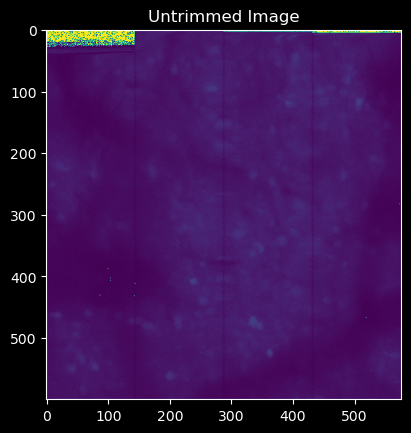

In [24]:
%matplotlib inline
# full image, no scan phase correction, no ROI trimming
plt.imshow(scan[0,0,:,:].squeeze())
plt.title('Untrimmed Image')
plt.show()

In [19]:
data = scan[:, 0, :, :].squeeze()
data.dtype

dtype('uint16')

In [14]:
data

dask.array<getitem, shape=(1730, 600, 576), dtype=uint16, chunksize=(194, 600, 576), chunktype=numpy.ndarray>

RFBOutputContext()

c:\Users\RBO\miniforge3\envs\mescore\lib\site-packages\fastplotlib\graphics\_features\_base.py:18: UserWarning: casting float64 array to float32
  warn(f"casting {array.dtype} array to float32")


JupyterWgpuCanvas()
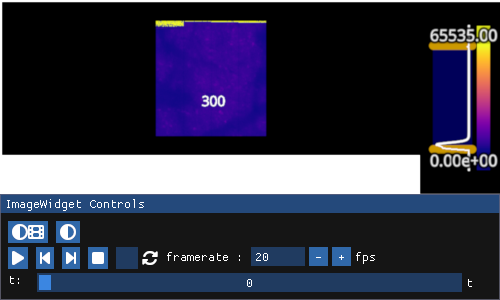

In [20]:
image_widget = fpl.ImageWidget(data.compute(), histogram_widget=True)
image_widget.show()

In [21]:
image_widget.close()

### First, without correcting for bi-directional scan phase

DEBUG:scanreader.scans:y_list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215

Roi data loaded in 0.0048143863677978516 seconds


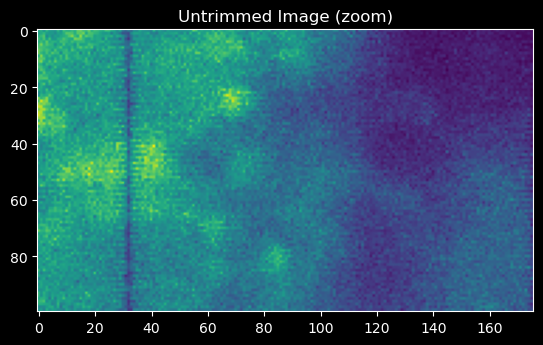

In [7]:
# scan.trim_x = (5,5)
# scan.trim_y = (17, 0)

plt.imshow(scan[2,0,400:600,300:400].squeeze())
plt.title('Untrimmed Image (zoom)')
plt.show()

### Next, with bi-directional scan phase correction

DEBUG:scanreader.scans:y_list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215

INFO:scanreader.scans:roi 0 with optimal phase shift of -1 px
INFO:scanreader.scans:roi 1 with optimal phase shift of -1 px
INFO:scanreader.scans:roi 2 with optimal phase shift of -1 px
INFO:scanreader.scans:roi 3 with optimal phase shift of 0 px


Roi data loaded in 0.0463261604309082 seconds


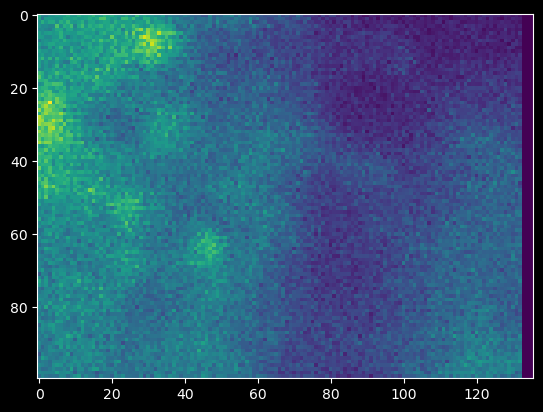

In [8]:
scan.fix_scan_offset = True

scan.trim_x = (5,5)
scan.trim_y = (17, 0)

plt.imshow(scan[2,0,400:600,300:400].squeeze())
plt.show()

the `scanreader.data` property will show you the size and chunkshape of the current state of the scanreader:

In [9]:
scan.data

dask.array<empty_like, shape=(1730, 600, 576), dtype=float64, chunksize=(48, 600, 576), chunktype=numpy.ndarray>

## Preview final output before starting the pre-processing routine.

1. fastplotlib
2. matplotlib
3. save to file (helpful for batch analysis)

## Saving Data Storage Options: Tiff, Zarr, HDF5

Zarr is the recommended datatype for this repository.

[Zarr documentation](https://zarr.readthedocs.io/en/stable/tutorial.html)

Deciding how to save data on a host operating system is far from straight foreward.
Read/write operations will vary widely between data saved in a **single file**
structure vs smaller chunks, e.g. one image per file, one image per epoch, etc. 
 
The former strategy is clean/consice and easy to handle but is *not* feasable with large (>10GB) datasets. 

- Zarr, similar to H5, is a heirarchical data storage specification.
- Zarr nicely hides the complexities inherent in linking filesystem heirarchy with efficient data I/O.

```python
name = '/path/to/folder'
chunksize=[300,300,1,1]
z1 = zarr.open(f'{name}', mode='w', shape=(data.shape),chunks=chunksize, dtype='int16')
```

In [ ]:
save_path

PosixPath('/home/mbo/caiman_data_org/animal_01/session_01/tiff')

## Tiff Output

Only run this if you saved a tiff output

In [ ]:
# To ensure the data was saved properly, load and display a single frame
start = time.time()
test_data = tifffile.imread()
print(time.time() - start)

plt.imshow(test_data[0, ...], cmap='gray')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\RBO\\caiman_data\\raw\\assembled\\assembled_plane_1.tiff'

## Zarr Output

Only run this if you saved a zarr output

In [22]:
saved_data = zarr.open(save_path) # type: ignore  # zarr accepts pathlib.Path obj
saved_data['plane_1'].info

Name,/plane_1
Type,zarr.core.Array
Data type,float64
Shape,"(3, 566, 526)"
Chunk shape,"(3, 566, 526)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,7145184 (6.8M)
No. bytes stored,1813968 (1.7M)


In [ ]:
zstack = save_path / 'roi_1'
[x for x in zstack.glob("*")]


[WindowsPath('C:/Users/RBO/caiman_data/raw/out/roi_1/plane_1.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/raw/out/roi_1/plane_10.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/raw/out/roi_1/plane_11.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/raw/out/roi_1/plane_12.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/raw/out/roi_1/plane_13.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/raw/out/roi_1/plane_14.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/raw/out/roi_1/plane_15.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/raw/out/roi_1/plane_16.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/raw/out/roi_1/plane_17.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/raw/out/roi_1/plane_18.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/raw/out/roi_1/plane_19.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/raw/out/roi_1/plane_2.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/raw/out/roi_1/plane_20.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/raw/out/roi_1/plane_21.tiff'),
 WindowsPath('C:/Users

In [30]:
p1 = zstack / 'plane_1.tiff'
data = tifffile.imread(p1)
data.shape

(1730, 1, 600, 144)

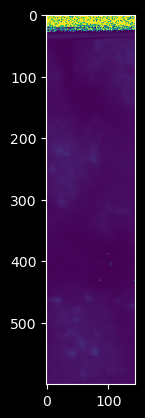

In [31]:
plt.imshow(data[0, 0, :, :])
plt.show()